# Example: Character Recognition

We'll apply the ideas we just learned to a neural network that does character recognition using the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database).  This
is a set of handwritten digits (0&ndash;9) represented as a 28&times;28 pixel grayscale image.

There are 2 datasets, the training set with 60,000 images and the test set with 10,000 images.  We will use a version of the data that is provided as CSV files:

* [mnist_train.csv.zip](mnist_train.csv.zip)
* [mnist_test.csv.zip](mnist_test.csv.zip)

Each line of these files provides the answer (i.e., what the digit is) as the first column and then the next 784 columns are the pixel values.

We'll write a class to managed this data:

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

A `TrainingDigit` provides a scaled floating point representation of the image as a 1D array (`.scaled`) as well as the correct answer (`.num`)
and categorical data that is used to represent the answer from the neural network&mdash;a 10 element array of 1s and 0s.  It also provides a method to plot the data.

In [2]:
class TrainingDigit:
    """a handwritten digit from the MNIST training set"""

    def __init__(self, raw_string):
        """we feed this a single line from the MNIST data set"""
        self.raw_string = raw_string

        # make the data range from 0.01 to 1.00
        _tmp = raw_string.split(",")
        self.scaled = np.asfarray(_tmp[1:])/255.0 * 0.99 + 0.01

        # the correct answer
        self.num = int(_tmp[0])

        # the output for the NN as a bit array -- make this lie in [0.01, 0.99]
        self.out = np.zeros(10) + 0.01
        self.out[self.num] = 0.99

    def plot(self, ax=None, output=None):
        """plot the digit"""
        if ax is None:
            fig, ax = plt.subplots()
        ax.imshow(self.scaled.reshape((28, 28)),
                  cmap="Greys", interpolation="nearest")
        if output is not None:
            dstr = [f"{n}: {v:6.4f}" for n, v in enumerate(output)]
            ostr = f"correct digit: {self.num}\n"
            ostr += "  ".join(dstr[0:5]) + "\n" + "  ".join(dstr[5:])
            plt.title(f"{ostr}", fontsize="x-small")

An `UnknownDigit` is like a `TrainingDigit` but it also provides a method to check if our prediction from the network is correct.

In [3]:
class UnknownDigit(TrainingDigit):
    """A digit from the MNIST test database.  This provides a method to
    compare a NN result to the correct answer

    """
    def __init__(self, raw_string):
        super().__init__(raw_string)
        self.out = None

    def interpret_output(self, out):
        """return the prediction from the net as an integer"""
        return np.argmax(out)
    
    def check_output(self, out):
        """given the output array from the NN, return True if it is
        correct for this digit"""
        return self.interpret_output(out) == self.num

Now we'll read in the data and store the training and test sets in separate lists.  We store the files as zipped files, so we need to unzip first.

In [4]:
import zipfile

In [5]:
training_set = []
with zipfile.ZipFile("mnist_train.csv.zip") as zf:
    with zf.open("mnist_train.csv") as f:
        for line in f:
            training_set.append(TrainingDigit(line.decode("utf8").strip("\n")))

In [6]:
len(training_set)

60000

In [7]:
test_set = []
with zipfile.ZipFile("mnist_test.csv.zip") as zf:
    with zf.open("mnist_test.csv") as f:
        for line in f:
            test_set.append(UnknownDigit(line.decode("utf8").strip("\n")))

In [8]:
len(test_set)

10000

Let's look at the first few digits in the training set

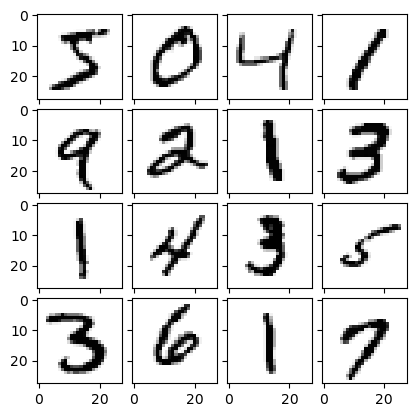

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1)
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.1)

for i, ax in enumerate(grid):
    training_set[i].plot(ax=ax)

Here's what the scaled pixel values look like&mdash;this is what will be fed into the network as input

In [10]:
training_set[0].scaled

array([0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01   

and here's what the categorical output looks like&mdash;this will be what we expect the network to return

In [11]:
training_set[0].out

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.99, 0.01, 0.01, 0.01, 0.01])

Now we can write our neural network class.  We will include a single hidden layer.

In [12]:
class NeuralNetwork:
    """A neural network class with a single hidden layer."""

    def __init__(self, input_size=1, output_size=1, hidden_layer_size=1):

        # the number of nodes/neurons on the output layer
        self.N_out = output_size

        # the number of nodes/neurons on the input layer
        self.N_in = input_size

        # the number of nodes/neurons on the hidden layer
        self.N_hidden = hidden_layer_size

        # we will initialize the weights with Gaussian normal random
        # numbers centered on 0 with a width of 1/sqrt(n), where n is
        # the length of the input state

        # A is the set of weights between the hidden layer and output layer
        self.A = np.random.normal(0.0, 1.0/np.sqrt(self.N_hidden), (self.N_out, self.N_hidden))

        # B is the set of weights between the input layer and hidden layer
        self.B = np.random.normal(0.0, 1.0/np.sqrt(self.N_in), (self.N_hidden, self.N_in))

    def g(self, xi):
        """our sigmoid function that operates on the hidden layer"""
        return 1.0/(1.0 + np.exp(-xi))

    def train(self, training_data, n_epochs=1, learning_rate=0.1):
        """Train the neural network by doing gradient descent with back
        propagation to set the matrix elements in B (the weights
        between the input and hidden layer) and A (the weights between
        the hidden layer and output layer)

        """

        print(f"size of training data = {len(training_data)}")
        
        for i in range(n_epochs):
            print(f"epoch {i+1} of {n_epochs}")

            random.shuffle(training_data)
            for n, model in enumerate(training_data):

                # make the input and output data one-dimensional
                x = model.scaled.reshape(self.N_in, 1)
                y = model.out.reshape(self.N_out, 1)

                # propagate the input through the network
                z_tilde = self.g(self.B @ x)
                z = self.g(self.A @ z_tilde)

                # compute the errors (backpropagate to the hidden layer)
                e = z - y
                e_tilde = self.A.T @ (e * z * (1 - z))

                # corrections
                dA = -2 * learning_rate * e * z * (1 - z) @ z_tilde.T
                dB = -2 * learning_rate * e_tilde * z_tilde * (1 - z_tilde) @ x.T

                self.A[:, :] += dA
                self.B[:, :] += dB

    def predict(self, model):
        """ predict the outcome using our trained matrix A """
        y = self.g(self.A @ (self.g(self.B @ model.scaled)))
        return y

Create our neural network

In [13]:
input_size = len(training_set[0].scaled)
output_size = len(training_set[0].out)
net = NeuralNetwork(input_size=input_size, output_size=output_size, hidden_layer_size=50)

Now we can train

In [14]:
net.train(training_set, n_epochs=5)

size of training data = 60000
epoch 1 of 5
epoch 2 of 5
epoch 3 of 5
epoch 4 of 5
epoch 5 of 5


Let's see what our accuracy rate is

In [15]:
n_correct = 0
for model in test_set:
    res = net.predict(model)
    if model.check_output(res):
        n_correct += 1

print(f"accuracy is {n_correct / len(test_set)}")

accuracy is 0.9673


So we are about 96% accurate.  We can try to improve this by training with more epochs or using a bigger hidden layer.  We might also try experimenting with [other activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions).

Let's look at some of the digits we get wrong

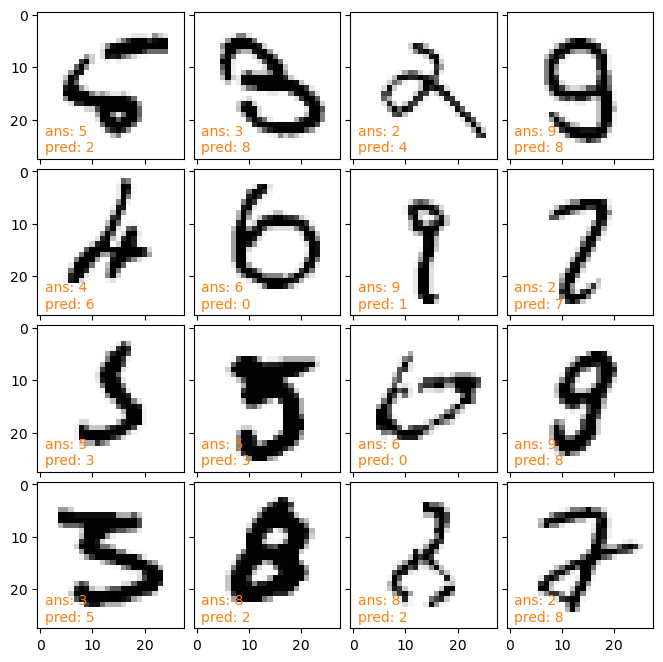

In [16]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (8, 8))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.1)

num_wrong = 0
for model in test_set:
    res = net.predict(model)
    if not model.check_output(res):
        model.plot(ax=grid[num_wrong])
        grid[num_wrong].text(0.05, 0.05,
                             f"ans: {model.num}\npred: {model.interpret_output(res)}",
                             transform=grid[num_wrong].transAxes,
                             color="C1", zorder=100)
        num_wrong += 1

    if num_wrong == len(grid):
        break